In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import os

from modules import network,mlp
from modules.memory_bank import StaticMemoryBank_for_MSLOSS
from modules.multi_similarity_loss import MultiSimilarityLoss, MultiSimilarityLoss_Boost
from utils import yaml_config_hook,save_model,data_preocess
from evaluation import  evaluation_tools
import warnings
warnings.filterwarnings("ignore")

In [2]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

class_num = args.classnum

In [3]:
x_ndarray,y_ndarray=data_preocess.data_process(x_path='data/filtered_Counts.npz',y_path='data/annoData.txt',args=args)

X Shape: (8569, 2000), Y Shape: (8569, 1)


In [4]:
from torch.utils.data import DataLoader,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features in scDataLoader:
    print(len(features))
    print(len(features[0]))
    break

1
512


In [5]:
mlpp=mlp.MLP()
model=network.Network(mlpp,feature_dim=args.feature_dim)
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [6]:
def train(ms_loss,memory_bank,model):
    loss_epoch=0
    for step,data in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        data,pseudolabel=memory_bank.generate_data(data[0].numpy())
        data=torch.tensor(data,dtype=torch.float32).to('cuda')
        pseudolabel=torch.tensor(pseudolabel,dtype=torch.long).to('cuda')
        embedding=model(data)
        loss=ms_loss(embedding,pseudolabel)
        loss.backward()
        optimizer.step()
        loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss:{loss.item()}")
            
    return loss_epoch

In [7]:
def validation(model,x_ndarray,y_ndarray,epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        x=torch.tensor(x_ndarray,dtype=torch.float32).to(device)
        embeddings=model.forward_embedding(x)
        embeddings=embeddings.detach().cpu().numpy()
        results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
        print(f'Epoch {epoch} with KMeans predict label\n' + f"ARI:{round(results['kmeans_ari'], 2)}  " + f"NMI:{round(float(results['kmeans_nmi']), 2)} \n")
        print(f'Epoch {epoch} with Leiden predict label\n' + f"ARI:{round(results['leiden_ari'], 2)}  " + f"NMI:{round(float(results['leiden_nmi']), 2)} \n")
        return results['kmeans_ari'],results['kmeans_nmi']


In [8]:
loss_device=torch.device('cuda')
memory_bank=StaticMemoryBank_for_MSLOSS(args.batch_size,x_ndarray,args.num_genes,args.NN_COUNT)
ms_loss=MultiSimilarityLoss_Boost(args=args)
losses=[]
aris=[]
nmis=[]


for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(ms_loss,memory_bank,model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 1 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    ari,nmi = validation(model,x_ndarray,y_ndarray,epoch)
    aris.append(ari)
    nmis.append(nmi)
    print('Test NMI = {:.4f} ARI = {:.4f} \n '.format(nmi, ari))

Step [0/16]	 loss:5.847832679748535
Step [2/16]	 loss:5.846676826477051
Step [4/16]	 loss:5.84495735168457
Step [6/16]	 loss:5.84288215637207
Step [8/16]	 loss:5.840322494506836
Step [10/16]	 loss:5.8364057540893555
Step [12/16]	 loss:5.833424091339111
Step [14/16]	 loss:5.831554412841797

Epoch [1/300]	 Loss: 5.84004870057106 

Epoch 1 with KMeans predict label
ARI:0.47  NMI:0.67 

Epoch 1 with Leiden predict label
ARI:0.57  NMI:0.76 

Test NMI = 0.6657 ARI = 0.4726 
 
Step [0/16]	 loss:5.828091144561768
Step [2/16]	 loss:5.827246189117432
Step [4/16]	 loss:5.823575496673584
Step [6/16]	 loss:5.821465492248535
Step [8/16]	 loss:5.8186140060424805
Step [10/16]	 loss:5.814952373504639
Step [12/16]	 loss:5.812153339385986
Step [14/16]	 loss:5.810688018798828

Epoch [2/300]	 Loss: 5.818886995315552 

Epoch 2 with KMeans predict label
ARI:0.51  NMI:0.69 

Epoch 2 with Leiden predict label
ARI:0.51  NMI:0.73 

Test NMI = 0.6941 ARI = 0.5150 
 
Step [0/16]	 loss:5.808330059051514
Step [2/16]

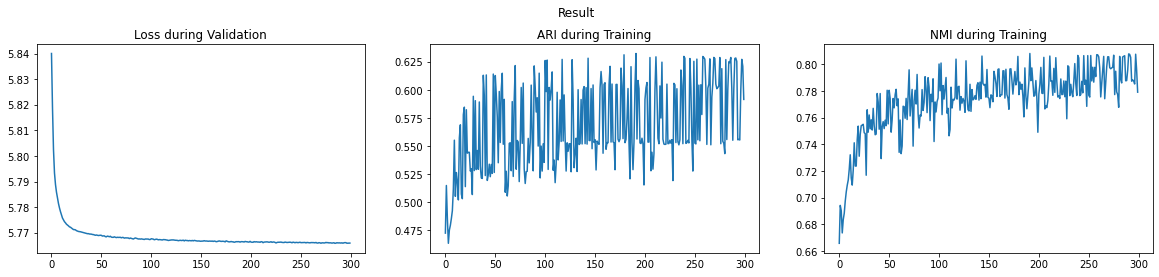

In [18]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
ax[0].plot(losses)
ax[0].set_title('Loss during Validation')
ax[1].plot(aris)
ax[1].set_title('ARI during Training')
ax[2].plot(nmis)
ax[2].set_title('NMI during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

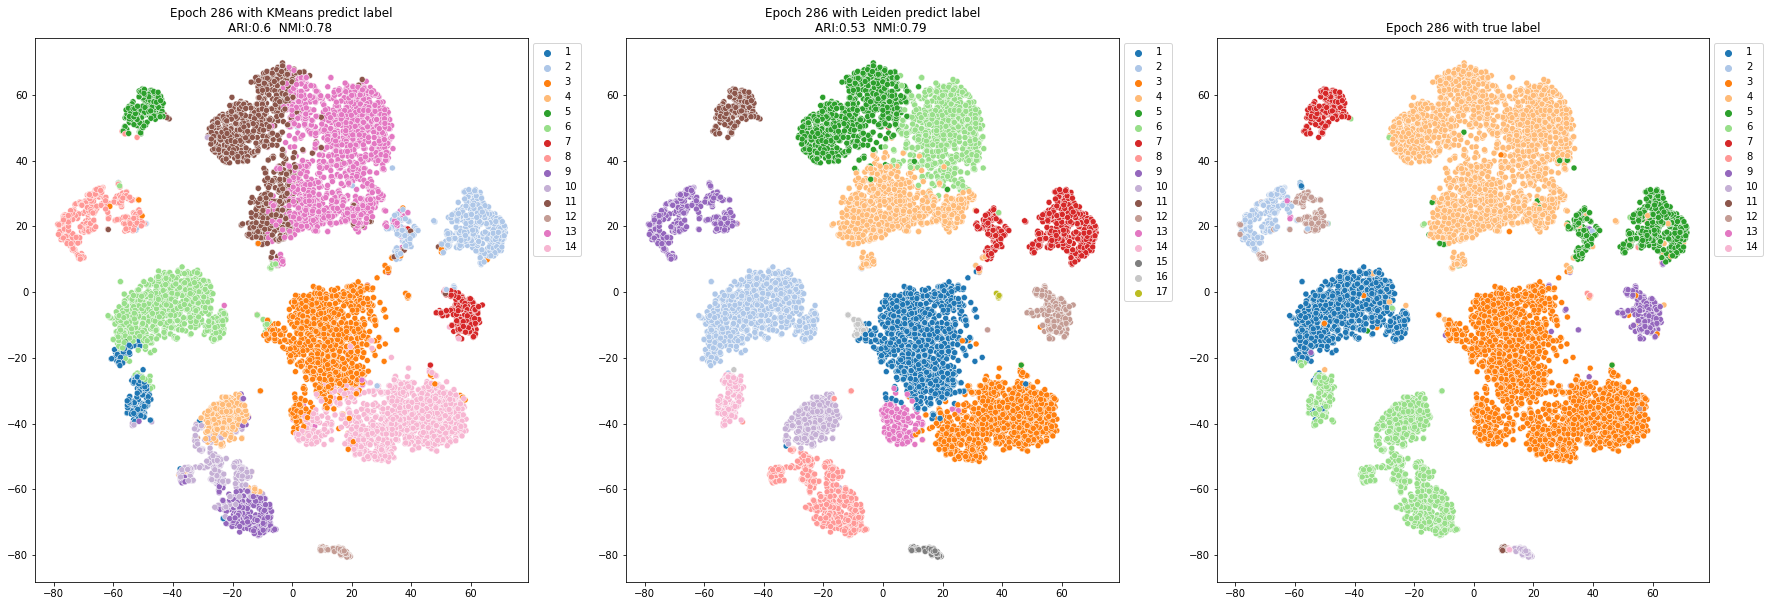

In [16]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_286.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=286)